In [1]:
try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    # Autoreload is optional; continue without it if unavailable
    pass

# Crisp plots in Jupyter without altering global styles
try:
    %config InlineBackend.figure_format = 'retina'
except Exception:
    pass

In [2]:
# =========================
# Standard library imports
# =========================
import os
import re
import json
import time
import shutil
import hashlib
import platform
import subprocess
from datetime import date
from pathlib import Path  # (deduped)
from typing import Union, Sequence, List, Dict, Any

# =========================
# Third-party libraries
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import yaml

from pyiron_workflow import Workflow
import kanapy as knpy
from orix.quaternion import Orientation
import damask

# =========================
# Console formatting (ANSI)
# - Use OLD for bold, RESET to clear styles
# - Colors: CYAN / YELLOW / RED
# =========================
OLD   = "\033[1m"
CYAN  = "\033[1;36m"
YELLOW= "\033[1;33m"
RED   = "\033[1;31m"
RESET = "\033[0m"

In [3]:
###############################################################################
# Step 1: Locate path to EBSD map
###############################################################################
@Workflow.wrap.as_function_node("path")
def locate_map_dir(file_extension: str, path: Union[str, Path, None]) -> str:
    """
    Find the first file with the given extension (e.g., '.ang') under `path`. 
    Returns the absolute path as a string.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 1: Locating EBSD file ...........................................................{RESET}")
    print("\n\n")

    # Ensure file_extension starts with a dot (e.g., ".ang")
    ext = file_extension if file_extension.startswith(".") else f".{file_extension}"
    ext = ext.lower()

    # Determine search root (do NOT convert to absolute; we keep things relative)
    search_root  = Path(path) if path is not None else Path.cwd()
    if not search_root.exists() or not search_root.is_dir():
        raise ValueError(f"The provided path '{search_root }' is not a valid directory.")

    found = None
    # Recursive walk; use os.path.join to construct paths
    for dirpath, _, filenames in os.walk(search_root ):
        for fname in filenames:
            if fname.lower().endswith(ext):
                found = os.path.join(dirpath, fname)
                break
        if found is not None:
            break

    if found is None:
        raise FileNotFoundError(f"No file with extension {ext} found in {search_root}")

    # Return relative path to the search root
    rel_path = os.path.relpath(found, start=search_root )

    print(f"{YELLOW}{OLD}Step 1 completed: Located file at {rel_path}{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return rel_path

In [4]:
###############################################################################
# Step 2: Load and read EBSD map using Kanapy
###############################################################################
@Workflow.wrap.as_function_node("knpyObject")
def load_ebsd_map(file_path: str, show_plot: bool = False) -> "object":
    """
    Load an EBSD map using Kanapy from `file_path`.
    Inputs:
      - file_path (str): Relative or absolute path to the EBSD file (e.g., .ang, .ctf).
      - show_plot (bool): If True, display the EBSD map visualization.
    Outputs:
      - ebsd (kanapy.EBSDmap): The loaded EBSD map object.
    """

    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 2: Loading EBSD map .............................................................{RESET}")
    print("\n\n")
    
    fp = Path(file_path)
    if not fp.exists():
        raise FileNotFoundError(f"{RED}{OLD}Invalid file path:{RESET} {file_path}. Please ensure the EBSD file exists.")

    ebsd = knpy.EBSDmap(str(fp), show_plot)

    print(f"{YELLOW}{OLD}Step 2 completed: EBSD map loaded from {fp}{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return ebsd 

In [5]:
###############################################################################
# Step 3: Extract statistical parameters from EBSD map or a JSON file
###############################################################################
@Workflow.wrap.as_function_node("statisticalDescriptors")
def get_stats(source, NVoxels: int = 25, sizeRVE: int = 25, periodic: bool = True) -> "dict":
    """
    Extract microstructure statistics from `source`.
    Inputs:
      - source (str | Path | EBSDmap): JSON file with precomputed stats OR a Kanapy EBSDmap.
      - NVoxels (int): Number of voxels for stats/voxelization grid (default 25).
      - sizeRVE (int): Target RVE size for stats generation (default 25).
      - periodic (bool): Use periodic RVE (default True).
    Outputs:
      - ms_stats (dict): Microstructure stats (grain size, aspect ratio, orientations, etc.).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 3: Extracting microstructure statistics .........................................{RESET}")
    print("\n\n")
    
    # Case 1: If the source is a JSON file, import precomputed statistics
    if isinstance(source, (str, Path)):
        src = str(source)
        if not src.lower().endswith(".json"):
            raise ValueError("Only JSON files can be imported as statistical parameters.")
        if not os.path.isfile(src):
            raise FileNotFoundError(f"The specified JSON file '{src}' does not exist.")
        try:
            ms_stats = knpy.import_stats(src)
        except Exception as error:
            raise ValueError(f"Error reading JSON file '{src}': {error}")

    # Case 2: If the source is Kanapy EBSDmap-like object, compute statistics
    else:
         # Validation for expected attributes
         if not hasattr(source, "ms_data"):
            raise ValueError("Invalid EBSD map object: missing attribute 'ms_data'.")
             
         try:
             # Extract microstructural data from the EBSD map object
             
             ms_data = source.ms_data[0]
             # Normalize phase name: lowercase + underscores
             matname = ms_data["name"].lower().replace(" ", "_")
             
             gs_param = ms_data['gs_param']  # parameters for log-normal distribution of grain size
             ar_param = ms_data['ar_param']  # parameters for log-normal distribution of aspect ratios
             om_param = ms_data['om_param']  # parameters for normal distribution of ellipsoid tilt angles

             # Compute statistics using knpy
             ms_stats = knpy.set_stats(
                 gs_param, 
                 ar_param, 
                 om_param,
                 deq_min=8.0, deq_max=19.0, asp_min=0.95, asp_max=3.5,omega_min=0.0, omega_max=np.pi, 
                 voxels=NVoxels, size=sizeRVE,periodicity=periodic,
                 VF=ms_data["vf"], phasename=matname, phasenum=0
             )

             ms_stats["Data"] = {
                "grain_size": ms_data.get("gs_data"),
                "aspect_ratio": ms_data.get("ar_data"),
            }

         except (KeyError, IndexError, AttributeError) as exc:
             raise ValueError(f"EBSD map object is missing expected fields: {exc}")
             
    print(f"{YELLOW}{OLD}Step 3 completed: Microstructure statistics extracted................................{RESET}")
    print(f"{CYAN}{OLD}#####################################################################################{RESET}\n")
    print("\n\n")
    return ms_stats

In [6]:
###############################################################################
# Step 4: create a RVE for simulating the microstructure of materials
###############################################################################
@Workflow.wrap.as_function_node("RVE")
def generate_rve(source: dict, ori: Union[str, object] = None, show_plots: bool = True) -> knpy.Microstructure:
    """
    Build a 3D RVE from microstructure stats in `source` and assign orientations.

    Inputs:
      - source (dict): Microstructure descriptor/stats (e.g., from knpy.set_stats()).
      - ori (str|object|None): 'goss' | 'copper' | 'random' OR a custom orientation object (e.g., ODF).

    Outputs:
      - ms (kanapy.Microstructure): The generated RVE (packed, voxelized, oriented).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 4: Generating RVE ...............................................................{RESET}")
    print("\n\n")
    
    # --- Minimal validation to avoid KeyErrors ---
    if not isinstance(source, dict):
        raise ValueError("`source` must be a dict (e.g., output of knpy.set_stats).")
    phase_dict = source.get("Phase") or {}
    material_name = phase_dict.get("Name")
    
    # 1) Create simulation box with ellipsoidal grains =================================================================
    ms = knpy.Microstructure(descriptor=source, name=f"{material_name}_RVE")
    ms.init_RVE()
    # Creates particle distribution (within the given lower and upper bounds)
    # inside simulation box (RVE) based on the data provided in the data file
    # ==================================================================================================================

    # 2) Perform particle packing ======================================================================================
    ms.pack()
    print("\n\n")
    if show_plots:
        ms.plot_ellipsoids()
    # Simulates grain packing in the box. Particles are initially downscaled
    # to avoid overlap and allow free movement. Collisions are handled during packing.
    # ==================================================================================================================

    # 3) Voxelize to 3D grid ===========================================================================================
    ms.voxelize()
    print("\n\n")
    if show_plots:
        ms.plot_voxels(sliced=True)
    # Converts the packed structure into a voxelated 3D mesh.
    #   Voxels inside grains are assigned to the grain phase, while others
    #   are filled according to a grain growth algorithm.
    # ==================================================================================================================
    print("\n\n")
    if show_plots:    
        ms.plot_stats_init(gs_data=source["Data"]["grain_size"], ar_data=source["Data"]["aspect_ratio"])
    
    # 4 - Assign orientations to grains ================================================================================
    if isinstance(ori, str):
        key = ori.lower().strip()
        if key == "goss":
            ang, omega, texture_desc = [0, 45, 0], 7.5, "unimodel"
        elif key == "copper":
            ang, omega, texture_desc = [90, 35, 45], 7.5, "unimodel"
        elif key == "random":
            ang, omega, texture_desc = None, None, "random"
        else:
            raise ValueError('Unsupported texture string in `ori`. Use "goss", "copper", or "random".')

        ms.generate_orientations(texture_desc, ang=ang, omega=omega, hist=None, Nbase=1000)
    else:
        # Custom orientation object (e.g., EBSD-derived ODF) or None
        ms.generate_orientations(ori) # downsample ODF of EBSD map to actual number of grains
    print("\n\n") 
    if show_plots:
        ms.plot_voxels(ori=True)  # plot voxelized grains in color code of IPF key
    # ==================================================================================================================
    print(f"{YELLOW}{OLD}Step 4 completed: RVE generated.......................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return ms # Return the generated microstructure object

In [7]:
@Workflow.wrap.as_function_node("dataSchema")
def write_data( source: knpy.Microstructure, fileName: str | Path, user_metadata: dict, boundary_condition: dict, phases: list, units: dict) -> dict:
    """
    Build and save a single JSON data-schema file from a Kanapy Microstructure.
    Inputs:
      - source (kanapy.Microstructure): Voxelized RVE to serialize.
      - fileName (str|Path): Output JSON path (e.g., "_workflow/data_schema.json").
      - user_metadata (dict): Freeform metadata to embed.
      - boundary_condition (dict): BC block to embed.
      - phases (list): Phase descriptors for write_dataSchema.
      - units (dict): Units map, e.g. {"length":"um","stress":"MPa"}.
    Outputs:
      - data (dict): The full data-schema dict that is written to disk.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 5: Exporting data ...............................................................{RESET}")
    print("\n\n")

    # 1) Validate basic inputs ---
    if not isinstance(user_metadata, dict):
        raise ValueError("user_metadata must be a dict")
    if not isinstance(boundary_condition, dict):
        raise ValueError("boundary_condition must be a dict")
    if not isinstance(phases, (list, tuple)):
        raise ValueError("phases must be a list/tuple")
    if not isinstance(units, dict):
        raise ValueError("units must be a dict")
        
    units_norm = {str(k).lower(): v for k, v in units.items()}
    length_unit = units_norm.get("length")
    if length_unit is None:
        length_unit = units.get("Length") or units.get("LENGTH")
    if length_unit is None:
        raise ValueError("units must contain a 'length' entry (e.g., {'length':'um'})")

    # 2) Build schema via Kanapy
    data = source.write_dataSchema(
        user_metadata=user_metadata,
        boundary_condition=boundary_condition,
        phases=phases,
        interactive=False,
        structured=True,
        length_unit=length_unit,
    )
    if not isinstance(data, dict) or not data:
        raise RuntimeError("write_dataSchema did not return a non-empty dict.")
    data["units"] = units # Add units to the data schema

    # 3) Locate grains robustly and validate orientations
    evo = data.get("microstructure_evolution")
    # If evo came back as a list, accept [ {...} ] as well
    if isinstance(evo, list):
        if len(evo) == 1 and isinstance(evo[0], dict):
            evo = evo[0]
        else:
            raise ValueError("Expected 'microstructure_evolution' as dict or single-element list of dict.")
    if not isinstance(evo, dict):
        raise ValueError("Missing or invalid 'microstructure_evolution' block (dict expected).")

    grains = evo.get("grains")
    if not isinstance(grains, list) or len(grains) == 0:
        raise ValueError("Missing or invalid 'grains' list inside 'microstructure_evolution'.")

    # Validate each grain has orientation [Phi1, Phi, Phi2]
    for i, g in enumerate(grains):
        if not isinstance(g, dict):
            raise ValueError(f"Grain at index {i} is not a dict: {type(g).__name__}")
        ori = g.get("orientation")
        if not (isinstance(ori, (list, tuple)) and len(ori) == 3):
            raise ValueError(f"Grain {i} has invalid 'orientation' (need [Phi1, Phi, Phi2]): {ori}")

    Phi1 = [g["orientation"][0] for g in grains]
    Phi  = [g["orientation"][1] for g in grains]
    Phi2 = [g["orientation"][2] for g in grains]
    n_gr = len(grains)

    # 4) Install Euler arrays in the Phase dict (phases[0].orientation.euler_angles) 
    p0 = data["phases"][0]
    p0.setdefault("orientation", {})
    p0["orientation"].setdefault("euler_angles", {})
    p0["orientation"]["euler_angles"]["Phi1"] = Phi1
    p0["orientation"]["euler_angles"]["Phi"]  = Phi
    p0["orientation"]["euler_angles"]["Phi2"] = Phi2
    p0["orientation"]["grain_count"] = n_gr

    # 5) Save JSON
    out_path = str(fileName)
    if not out_path.lower().endswith(".json"):
        out_path += ".json"
    parent = os.path.dirname(out_path)
    if parent and not os.path.isdir(parent):
        os.makedirs(parent, exist_ok=True)

    print("\n\n")
    print("type:", type(data))
    print("\n\n")
    print("preview:", repr(data)[:200])
    print("\n\n")

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print("Saved to:", os.path.abspath(out_path))

    print(f"{YELLOW}{OLD}Step 5 completed: data saved in JSOn file.............................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return data

In [8]:
###############################################################################
# Step 6: Writing grid, material, and load files to start a DAMASK simulation
###############################################################################
@Workflow.wrap.as_function_node("grid", "material", "load")
def load_to_damask(
    source: dict,
    load: List[List[Union[float, str]]] | List[List[List[Union[float, str]]]],
    grid_out: Union[str, Path] = "grid.vti",
    material_out: Union[str, Path] = "material.yaml",
    load_out: Union[str, Path] = "load.yaml",
    t_list: Sequence[float] = (50.0,),     # total time per step
    N_list: Sequence[int]   = (100,),       # number of increments per step
    f_out_list: Sequence[int] = (1,),       # write results every f_out increments
    outputs: Sequence[str] = ("F", "P", "F_p", "F_e", "L_p", "O"),
):
    """
    Build DAMASK grid/material/load files from a schema-like `source`.

    Inputs:
      - source (dict): Data schema used by DAMASK helpers (kanapy→DAMASK).
      - load (3x3 or list of 3x3): Deformation-rate matrices per step (numbers or 'x').
      - grid_out/material_out/load_out (str|Path): Output filenames (relative or absolute).
      - t_list, N_list, f_out_list: Per-step times, increments, and output stride.
      - outputs (list[str]): Mechanical outputs to request.

    Outputs:
      - (grid_path, material_path, load_path) as strings (relative to CWD if given that way).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 6: Building grid/material/load from JSON ........................................{RESET}")
    print("\n\n")
    
    # 1) Basic validation of input JSON ----------------
    if not isinstance(source, dict):
        raise TypeError("`source` must be a dict.")
    if "phases" not in source or not isinstance(source["phases"], list) or len(source["phases"]) == 0:
        raise KeyError("Missing or empty 'phases' array in source.")
    phases_in = source["phases"]

    # 2) Validate step schedules ----------------
    if not (len(t_list) == len(N_list) == len(f_out_list)):
        raise ValueError("t_list, N_list, and f_out_list must have the same length.")
    num_steps = len(t_list)

    for i, (t, N, f) in enumerate(zip(t_list, N_list, f_out_list), start=1):
        if not (isinstance(t, (int, float)) and t > 0):
            raise ValueError(f"Step {i}: t must be > 0 (got {t}).")
        if not (isinstance(N, int) and N >= 1):
            raise ValueError(f"Step {i}: N must be an integer >= 1 (got {N}).")
        if not (isinstance(f, int) and 1 <= f <= N):
            raise ValueError(f"Step {i}: f_out must be an integer in [1, N] (got {f}).")

    # 3) Normalize `load` per your rule ----------------
    # Check if `load` is a single 3x3 matrix
    is_single_3x3 = (
        isinstance(load, list) and
        len(load) == 3 and all(isinstance(row, list) and len(row) == 3 for row in load))
    
    if num_steps == 1:
        # Allow either a 3x3 or a list with one 3x3
        if is_single_3x3:
            loads_per_step = [load]  # wrap single 3x3 as a list of length 1
        else:
            # Is it a list with one 3x3?
            is_list_with_one_3x3 = (
                isinstance(load, list) and
                len(load) == 1 and
                isinstance(load[0], list) and
                len(load[0]) == 3 and
                all(isinstance(r, list) and len(r) == 3 for r in load[0])
            )
            if not is_list_with_one_3x3:
                raise ValueError(
                    "For one step: `load` must be a 3x3 matrix or a list containing one 3x3 matrix."
                )
            loads_per_step = load  # already [3x3]
    else:
        # For multiple steps: require list of length num_steps, each entry a 3x3
        is_list_of_3x3 = (
            isinstance(load, list) and
            len(load) == num_steps and
            all(
                isinstance(m, list) and len(m) == 3 and
                all(isinstance(r, list) and len(r) == 3 for r in m)
                for m in load
            )
        )
        if not is_list_of_3x3:
            raise ValueError(
                f"For {num_steps} steps: `load` must be a list of {num_steps} items, each a 3x3 matrix. "
                "Even if identical, repeat the 3x3 per step."
            )
        loads_per_step = load

    # 4) Geometry ----------------
    grid = damask.GeomGrid.load_kanapy(source)
    grid.save(str(grid_out))
    print(grid)
    print("\n\n")
    # 5) Material (build all phases from `source['phases']`) ----------------
    cfg = damask.ConfigMaterial.load_kanapy(source)
    print(cfg)
    print("\n\n")
    phase_dict: Dict[str, Any] = {}
    

    for p in phases_in:
        pid = p.get("phase_id")
        phase_key = f"{pid}" if pid is not None else None 
        if phase_key is None:
            raise ValueError("Phase entry lacks 'phase_id'.")

        cm = p.get("constitutive_model")
        if not isinstance(cm, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'constitutive_model'.")

        elastic = cm.get("elastic_parameters")
        if not isinstance(elastic, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'elastic_parameters'.")
        for k in ("C11", "C12", "C44"):
            if k not in elastic:
                raise KeyError(f"Phase '{phase_key}' missing elastic parameter '{k}'.")

        # Accept Pa as-is; convert 100..1000 (GPa) → Pa
        C11 = float(elastic["C11"])
        C12 = float(elastic["C12"])
        C44 = float(elastic["C44"])
        
        plastic_params = cm.get("plastic_parameters")
        plasticity_type = cm.get("plastic_model_name")

        if not plasticity_type:
            raise KeyError(f"Phase '{phase_key}' missing 'plastic_model_name'.")
        if not isinstance(plastic_params, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'plastic_parameters' dictionary.")
    
        plastic_block = {"type": plasticity_type}
        plastic_block.update(plastic_params)

        phase_dict[phase_key] = {
            "lattice": "cF",  # FCC for Al; change if your JSON provides lattice info
            "mechanical": {
                "output": list(outputs),
                "elastic": {"type": "Hooke", "C_11": C11, "C_12": C12, "C_44": C44},
                "plastic": plastic_block,
            }
        }

    cfg.update(phase=phase_dict)
    if hasattr(cfg, "is_complete") and not cfg.is_complete:
        raise ValueError("material.yaml is not complete after update (check phases/mechanics).")
    cfg.save(str(material_out))

    # 6) Loadcase (user-defined number of steps) ----------------
    loadsteps = []
    for i in range(num_steps):
        dot_F = loads_per_step[i]
        # P-mask: set 'x' entries to 0;and set numeric entries to 'x'
        P = [[0 if (isinstance(v, str) and v.strip().lower() == 'x') else 'x' for v in row]
     for row in dot_F]

        loadsteps.append({
            "boundary_conditions": {"mechanical": {"dot_F": dot_F, "P": P}},
            "discretization": {"t": float(t_list[i]), "N": int(N_list[i])},
            "f_out": int(f_out_list[i]),
        })

    lc = damask.LoadcaseGrid(
        solver={"mechanical": "spectral_basic"},
        loadstep=loadsteps,
    )
    lc.save(str(load_out))
    print(f"{YELLOW}{OLD}Step 6 completed: Files are written..................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    grid = str(Path(grid_out).resolve())
    material = str(Path(material_out).resolve())
    loadcase = str(Path(load_out).resolve())  
    return grid, material, loadcase
        

In [9]:
###############################################################################
# Step 7: Running DAMASK simulations using the FFT grid (spectral) solver
###############################################################################
@Workflow.wrap.as_function_node("results")
def run_damask( grid_file: Union[str, Path], material_file: Union[str, Path], load_file: Union[str, Path] ) -> str:
    """
    Run DAMASK_grid with the provided grid/material/load files.

    Inputs:
      - grid_file (str|Path): Path to grid (.vti).
      - material_file (str|Path): Path to material (.yaml).
      - load_file (str|Path): Path to loadcase (.yaml).

    Outputs:
      - fn_hdf (str): Path to the produced HDF5 results file.
    """
    print(f"{CYAN}{OLD}#########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 7: Start Simulation ..............................................................{RESET}")
    print("\n\n")
    
    # 1) Resolve & validate input paths -------------------------------------------------
    # Use Path for robust path manipulations and clearer file name handling.
    fn_geometry = Path(grid_file)
    fn_material = Path(material_file)
    fn_load     = Path(load_file)

    if not fn_geometry.is_file():
        raise FileNotFoundError(f"Geometry file not found: {fn_geometry}")
    if not fn_material.is_file():
        raise FileNotFoundError(f"Material file not found: {fn_material}")
    if not fn_load.is_file():
        raise FileNotFoundError(f"Load file not found: {fn_load}")

    # Ensure the DAMASK solver is available on PATH.
    if shutil.which("DAMASK_grid") is None:
        raise RuntimeError("DAMASK_grid not found in PATH. Activate your DAMASK env or add it to PATH.")

    # 2) Build the command --------------------------------------------------------------
    # Prefer passing a list to Popen over shell=True to avoid shell quirks and quoting issues.
    cmd = [
        "DAMASK_grid",
        "-g", str(fn_geometry),
        "-l", str(fn_load),
        "-m", str(fn_material),
    ]
    print("Running:", " ".join(cmd))

    # 3) Launch process & stream output -------------------------------------------------
    # Merge stderr into stdout so we can stream everything in order and avoid potential deadlocks.
    # text=True gives us str lines; bufsize=1 enables line-buffered streaming.
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,
    )

    # Print solver output live (useful inside notebooks / CI logs).
    for line in process.stdout:
        print(line, end="")

    # Wait for completion and get return code.
    process.wait()

    # 4) Post-process result ------------------------------------------------------------
    if process.returncode != 0:
        print("Error during simulation (non-zero return code).")
        fn_hdf = False  # keep your original sentinel for failure
    else:
        print("Simulation completed successfully.")
        # Many DAMASK runs name the HDF5 as "<geom>_<load>_<mat>.hdf5".
        # Use Path.stem to strip extensions robustly (e.g., ".vti", ".yaml").
        out_name = f"{fn_geometry.stem}_{fn_load.stem}_{fn_material.stem}.hdf5"
        fn_hdf = out_name  # keep as string to match your existing downstream expectations

    print(f"{YELLOW}{OLD}Step 7 completed: Simulation finished ..................................................{RESET}")
    print(f"{CYAN}{OLD}########################################################################################{RESET}\n")
    print("\n\n")
    return fn_hdf

In [10]:
###############################################################################
# Step 8: Post-processing after
###############################################################################
@Workflow.wrap.as_function_node
def post_processing(results: str, grid_file: Union[str, Path], path: Union[str, Path]):
    """
    Post-process a DAMASK HDF5 result and its grid.

    Inputs:
      - results (str|Path): Path to the .hdf5 output from DAMASK.
      - grid_file (str|Path): Path to the .vti grid file.

    Outputs:
      - True (bool): Returned when processing completes without errors.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 8: Start postprocessing .........................................................{RESET}")
    print("\n\n")

    # 1) Locate result file ----------------
    fn_hdf = str(results)
    if not os.path.exists(fn_hdf):
        raise FileNotFoundError(f"Result file not found: {fn_hdf}")

    # 2) Load results ----------------------
    result = damask.Result(fn_hdf)

    # Try to add common derived fields (skip gracefully if already present / unsupported)
    try:
        result.add_stress_Cauchy("P", "F")                         # -> 'sigma'
        result.add_strain("F")                                # -> 'epsilon_V^0.0(F)' (log strain) strain tensor of F
        result.add_equivalent_Mises('sigma')             # -> 'sigma_vM'
        result.add_equivalent_Mises('epsilon_V^0.0(F)')  # -> 'epsilon_vM'
        result.add_IPF_color(l = [1,0,0], q = 'O')       # -> RGB color tuple of inverse pole figure (IPF) color
    except ValueError as e:
        print(f"Skipping variable addition: {e}")

    # Optional quick viewer for the last increment (ignore if not available in headless runs)
    try:
        result.view(increments=-1)
    except Exception as e:
        print(f"Viewer skipped: {e}")

    # 3) Export VTK for ParaView ----------
    
    base_out = str(path)
    vtk_dir = os.path.join(base_out, "vtk")
    os.makedirs(vtk_dir, exist_ok=True)
    try:
        result.export_VTK(target_dir=vtk_dir)
        print("Exported VTK to:", vtk_dir)
    except Exception as e:
        print(f"VTK export skipped: {e}")

    # 4) Load grid  ------------
    grid = damask.GeomGrid.load(grid_file)

    # Precompute useful arrays
    mat_flat = grid.material.flatten(order='F')
    grain_ids = np.unique(mat_flat)
    n_grains = int(grain_ids.max()) + 1 if grain_ids.size else 0

    # ------------------------------------------------------------------------------
    # 5) Average stress–strain curve
    # ------------------------------------------------------------------------------
    
    cumulative_data = []  # Use a list for more efficient data accumulation 
        
    for inc in result.get(['epsilon_V^0.0(F)', 'P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']

        # loop grains, average P11 per grain
        for g in range(n_grains):  
            points = (mat_flat == g)
            if np.sum(points) == 0:  # Ensure points exist
                continue
                    
            P_11 = P[points, 0, 0].flatten()
            epsilon_11 = np.full_like(P_11, epsilon[:, 0, 0].mean())  # Ensure shape consistency
            grain_data = pd.DataFrame({'epsilon_11': epsilon_11, 'P_11': P_11})
            cumulative_data.append(grain_data)  # Append data to list
        
    cumulative_data = pd.concat(cumulative_data, ignore_index=True)  # Convert to DataFrame once
    average_data = cumulative_data.groupby('epsilon_11', as_index=False).mean()
    
    # Plot results
    sns.lineplot(x='epsilon_11', y='P_11', data=average_data, marker='o')
    plt.xlabel("Average ε11")
    plt.ylabel("Average P11")
    plt.title("Average Stress-Strain Response Across All Grains")
    plt.show()
    plt.savefig('stress_strain.png')

    # ------------------------------------------------------------------------------
    # 6) Per-grain stress–strain curves for a few grains (0..3)
    #    - x: RVE-average ε_11 per increment
    #    - y: grain-average P_11 per increment
    # ------------------------------------------------------------------------------
    # Run the function
    grains = [0,1,2,3,4,5,6,7,8,9,10]
    data = {g:pd.DataFrame() for g in grains}
    for inc in result.get(['epsilon_V^0.0(F)','P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']
        for g in grains:
            points = (mat_flat == g)
            P_11 = P[points,0,0].flatten()
            epsilon_11 = np.broadcast_to(np.average(epsilon[:,0,0]),P_11.shape)
            x = pd.DataFrame({'epsilon_11':epsilon_11,'P_11':P_11})
            data[g] = pd.concat((data[g],x),ignore_index=True)
    for g in grains:
        plot = sns.lineplot(y='P_11',x='epsilon_11',data=data[g])
    fig = plot.get_figure()
    plt.xlabel("ε11")
    plt.ylabel("P11")
    plt.title("Per-grain Stress–Strain Response")
    plt.show()
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 8 completed: End of postprocessing ........................................................{RESET}")
    print("\n\n")
    return


In [11]:
# Microstructure descriptors:
nvox = 30                   # number of voxels in each Cartesian direction (cuboid RVE)
lside = 30                  # side length in micron in each Cartesian direction
periodic_RVE = True         # create periodic RVE
periodicBC = True           # apply periodic boundary conditions
file_ext = ".ang"           # file extension

# Directory where the workflow is executed
source_path = Path.cwd()

# JSON file name 
file_name = "data_schema_damask.json"

# input of data schema
user_metadata = {
    'identifier': 'c779c1a4',
    'title': 'Stress-Strain Analysis...',
    'date': '2025-08-01',
    'description': 'Stress-strain analysis of polycrystalline copper...',
    'rights': 'Creative Commons Attribution 4.0 International',
    'rights_holder': ['Rezek, Yousef'],
    'creator': ['Rezek, Yousef'],
    'creator_ORCID': None,
    'creator_affiliation': ['Ruhr University Bochum'],
    'creator_institute': ['ICAMS'],
    'creator_group': ['Micromechanical and Macroscopic Modelling'],
    'contributor': ['Hartmaier, Alexander'],
    'contributor_ORCID': ['0000-0002-3710-1169'],
    'contributor_affiliation': ['Ruhr University Bochum'],
    'contributor_institute': ['ICAMS'],
    'contributor_group': ['Micromechanical and Macroscopic Modelling'],
    'shared_with': [{'access_type': 'c'}, {'access_type': 'all'}],
    'funder_name': 'DFG',
    'fund_identifier': '190389738—TRR103',
    'publisher': 'Zenodo',
    'relation': ['10.1088/2632-2153/ad379e'],
    'keywords': ['CPFEM','Workflow','Uni-axial loading']
}

boundary_condition = {
    'mechanical_BC': [
        {
            'vertex_list': ['V000','V001'],
            'constraints': ['fixed','fixed','loaded'],
            'loading_type': 'force',
            'loading_mode': 'static',
            'applied_load': [
                {'magnitude': -40.9775, 'frequency': 0, 'duration': 250, 'R': 0},
                {'magnitude': -9.5384,  'frequency': 0, 'duration': 250, 'R': 0}
            ]
        },
        {
            'vertex_list': ['V101','V102','V202'],
            'constraints': ['loaded','fixed','loaded'],
            'loading_type': 'displacement',
            'loading_mode': 'monotonic',
            'applied_load': [
                {'magnitude': 0.001,  'frequency': 0, 'duration': 100, 'R': 0}
            ]
        },
        {
            'vertex_list': ['V011'],
            'constraints': ['free','loaded','fixed'],
            'loading_type': 'stress',
            'loading_mode': 'cyclic',
            'applied_load': [
                {'magnitude': 150.0, 'frequency': 5, 'duration': 200, 'R': 0.1},
                {'magnitude': -150.0,'frequency': 5, 'duration': 200, 'R': 0.1}
            ]
        }
    ]
}

units = {
        "Stress": "Pa",
        "Strain": 1,
        "Length": "µm",
        "Angle": "Radian",
        "Temperature": "Kelvin",
        "Force": "N",
        "Stiffness": "Pa"
    }

phases = [
        {
            "phase_id": 0,
            "material_identifier": "Martensite",
            "constitutive_model": {
                "$schema": "https://raw.githubusercontent.com/Ronakshoghi/MetadataSchema/main/crystal_plasticity_constitutive_model_metadata_schema.json",
                "elastic_model_name": "hooke",
                "elastic_parameters": {
                    "C11": 106.75e+9,
                    "C12": 60.41e+9,
                    "C44": 28.34e+9
                },
                "plastic_model_name": "phenopowerlaw",
                "plastic_parameters": {
                    "N_sl": [12],
                    "a_sl": [2.25],
                    "atol_xi": 1.0,
                    "dot_gamma_0_sl": [0.001],
                    "h_0_sl-sl": [75.e+6],
                    "h_sl-sl": [1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                    "n_sl": [20],
                    "output": ["xi_sl"],
                    "xi_0_sl": [31.e+6],
                    "xi_inf_sl": [63.e+6]
                    
                },
                "units": {
                    "Stress": "Pa",
                    "Stiffness": "Pa"
                }
            },
            "orientation": {
                "euler_angles": {
                    "Phi1": [],
                    "Phi": [],
                    "Phi2": []
                },
                "grain_count": None,
                "global_rotation_convention": "ZXZ",
                "texture_type": None,
                "software": "orix",
                "software_version": "0.13.0"
            }
        }
    ]

dot_F = [
        [[-0.004, 0.0, 0.0],[0.0, 'x', 0.0],[0.0, 0.0, 'x']]
    ]

In [12]:
# ===============================
# Define and initialize workflow
# ===============================
wf = Workflow("kanapy2DAMASK_workflow")

# -------------------------
# Step 1: Locate EBSD file
# -------------------------
wf.locate_map_dir = locate_map_dir(file_extension=file_ext, path=str(source_path))
if wf.locate_map_dir is None:
    raise ValueError("Step 1 failed: No file with specified extension found.")

# -------------------------
# Step 2: Load and read EBSD Map
# -------------------------
wf.load_ebsd_map = load_ebsd_map(file_path=wf.locate_map_dir, show_plot=True)
if wf.load_ebsd_map is None:
    raise ValueError("Step 2 failed: Kanapy could not load the EBSD map.")

# -------------------------
# Step 3: Get microstructure statistics
# -------------------------
wf.get_stats = get_stats(source=wf.load_ebsd_map, NVoxels=nvox, sizeRVE=lside, periodic=periodic_RVE)
if wf.get_stats is None:
    raise ValueError("Step 3 failed: Kanapy could not extract microstructure statistics.")

# -------------------------
# Step 4: Generate RVE
# -------------------------
wf.generate_rve = generate_rve(source=wf.get_stats,ori=wf.load_ebsd_map, show_plots=True)
if wf.generate_rve is None:
    raise ValueError("Step 4 failed: RVE generation failed.")

# -------------------------
# Step 5: Export JSON data schema
# -------------------------
wf.write_data = write_data(source=wf.generate_rve, fileName=file_name, user_metadata=user_metadata,
                              boundary_condition=boundary_condition, phases=phases, units=units)
if wf.write_data is None:
    raise ValueError("Step 5 failed: Json data schema file generation failed.")

# -------------------------
# Step 6: Write grid, material, load files
# -------------------------
wf.load_to_damask = load_to_damask(source=wf.write_data, load = dot_F)
grid_path, material_path, loadcase_path = wf.load_to_damask.outputs["grid"], wf.load_to_damask.outputs["material"], wf.load_to_damask.outputs["load"]

# -------------------------
# Step 7: Start simulation in DAMASK
# -------------------------
wf.run_damask = run_damask(grid_file=grid_path , material_file=material_path, load_file=loadcase_path )

# -------------------------
# Step 8: Postprocessing
# -------------------------
wf.post_processing =post_processing(results = wf.run_damask, grid_file = wf.load_to_damask.outputs.grid, path = str(source_path))

INFO:pyiron_log:Assigning a channel with the label file_extension to the io key locate_map_dir__file_extension
INFO:pyiron_log:Assigning a channel with the label path to the io key locate_map_dir__path
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key load_ebsd_map__show_plot
INFO:pyiron_log:Assigning a channel with the label NVoxels to the io key get_stats__NVoxels
INFO:pyiron_log:Assigning a channel with the label sizeRVE to the io key get_stats__sizeRVE
INFO:pyiron_log:Assigning a channel with the label periodic to the io key get_stats__periodic
INFO:pyiron_log:Assigning a channel with the label show_plots to the io key generate_rve__show_plots
INFO:pyiron_log:Assigning a channel with the label fileName to the io key write_data__fileName
INFO:pyiron_log:Assigning a channel with the label user_metadata to the io key write_data__user_metadata
INFO:pyiron_log:Assigning a channel with the label boundary_condition to the io key write_data__boundary_condition
INFO

########################################################################################
Step 1: Locating EBSD file ...........................................................



Step 1 completed: Located file at ebsd_316L_500x500.ang
######################################################################################




########################################################################################
Step 2: Loading EBSD map .............................................................



Imported EBSD map with 1 phases.
Initial number of bad pixels: 3040
After 3041 loops: number of bad pixels: 0
Identifying regions of homogeneous misorientations and assigning them to grains.
Phase #0 (Iron fcc): Identified Grains: 351
Building microstructure graph.
Starting to simplify microstructure graph.


INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Fallback to method "raw" due to exception No valid ellipsis parameters found..
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to m

After merging of similar regions, 245 grains left.
After elimination of small grains, 245 grains left.


INFO:root:Too few points on grain hull, fallback to method "raw".
INFO:root:Too few points on grain hull, fallback to method "raw".



--------------------------------------------------------
Statistical microstructure parameters in pixel map 
--------------------------------------------------------
14.28023755285528 29.147557352948027
4.969715816230545 11.617900778578223
15.491584090777478 31.115296713228577


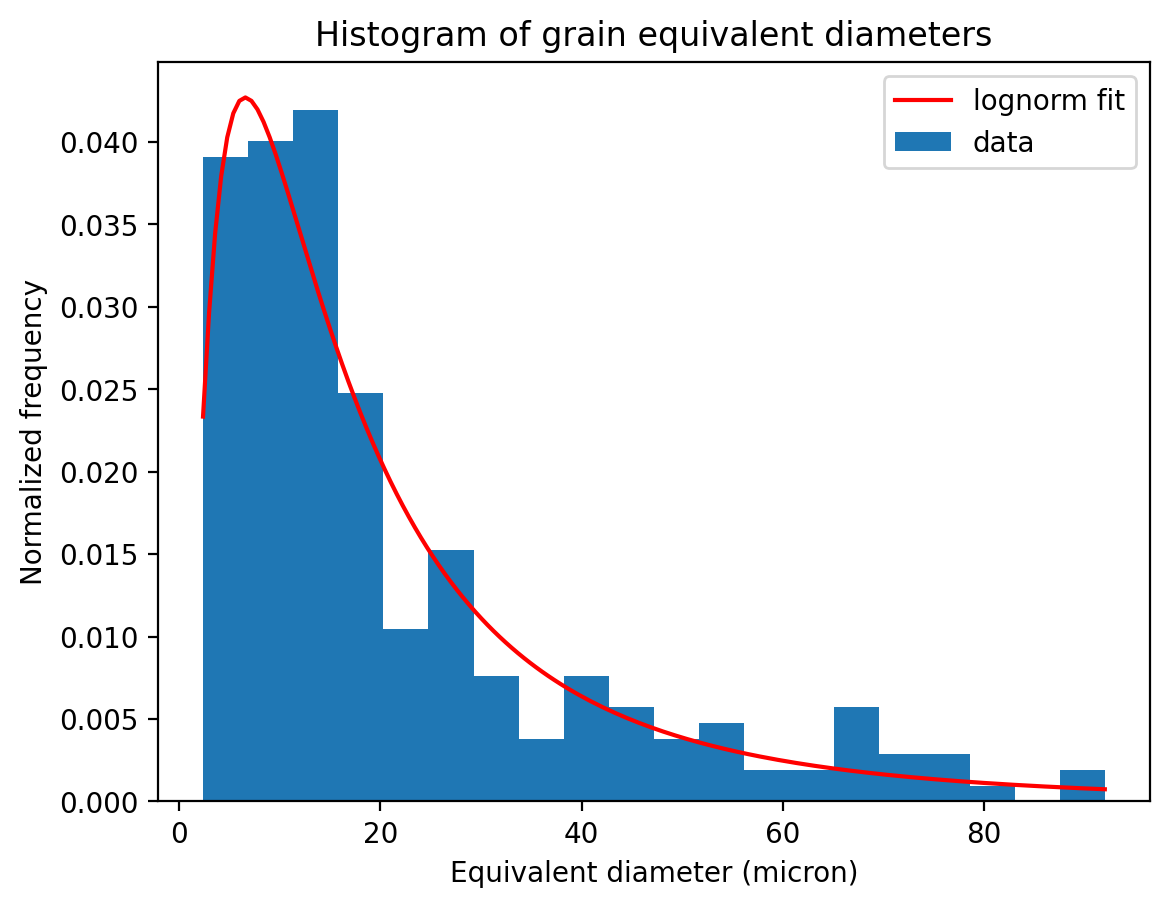

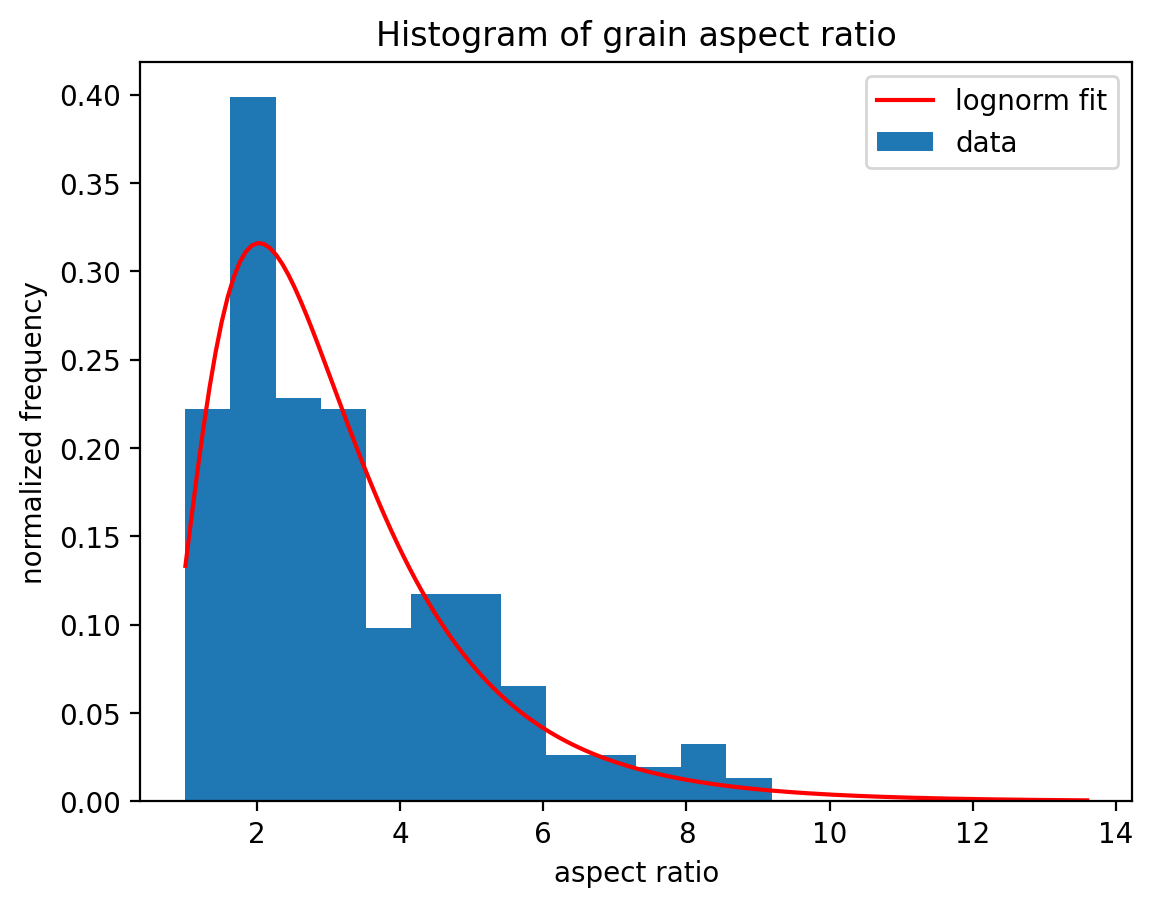

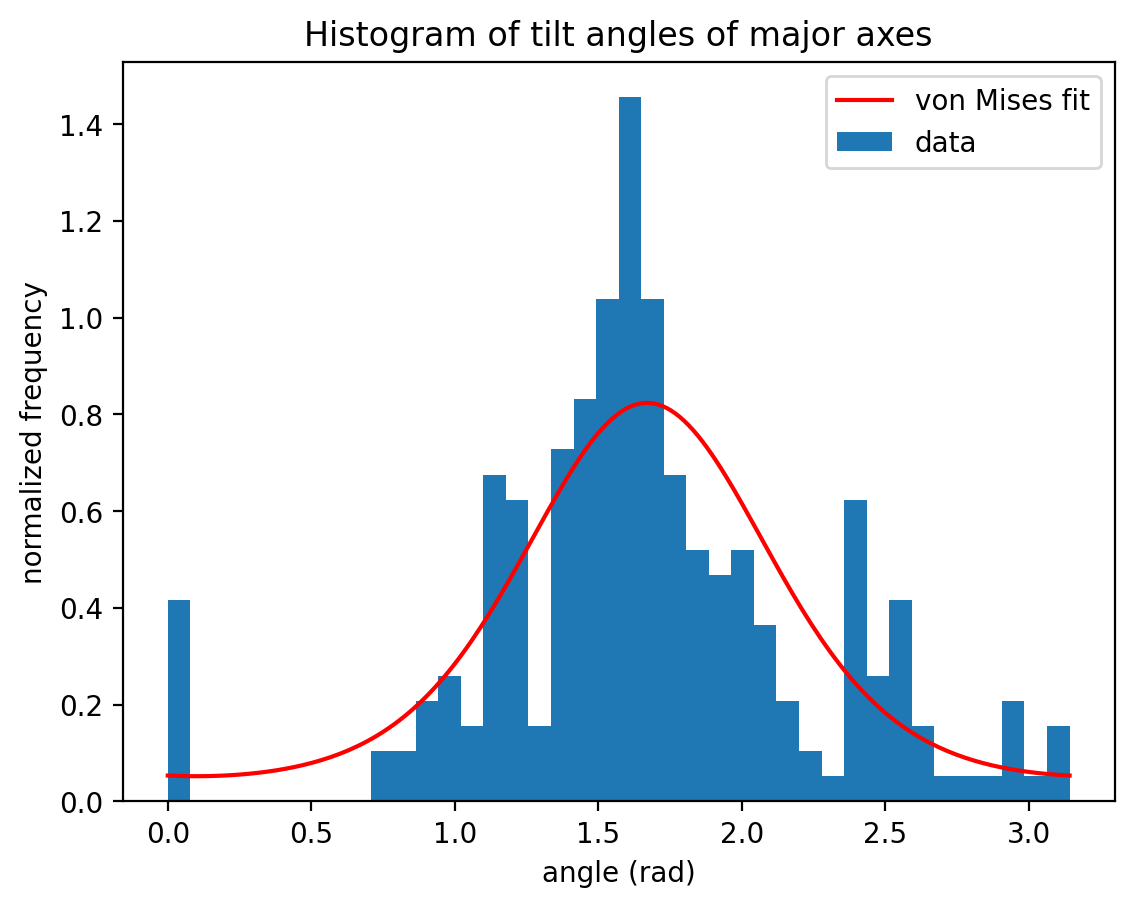

Analyzed microstructure of phase #0 (Iron fcc) with 245 grains.
Median values: equiv. diameter: 15.492 micron, aspect ratio: 2.71, tilt angle: 11.298°
Std. dev: equivalent diameter: 0.928 micron, aspect ratio: 0.538, tilt angle: 62.621°


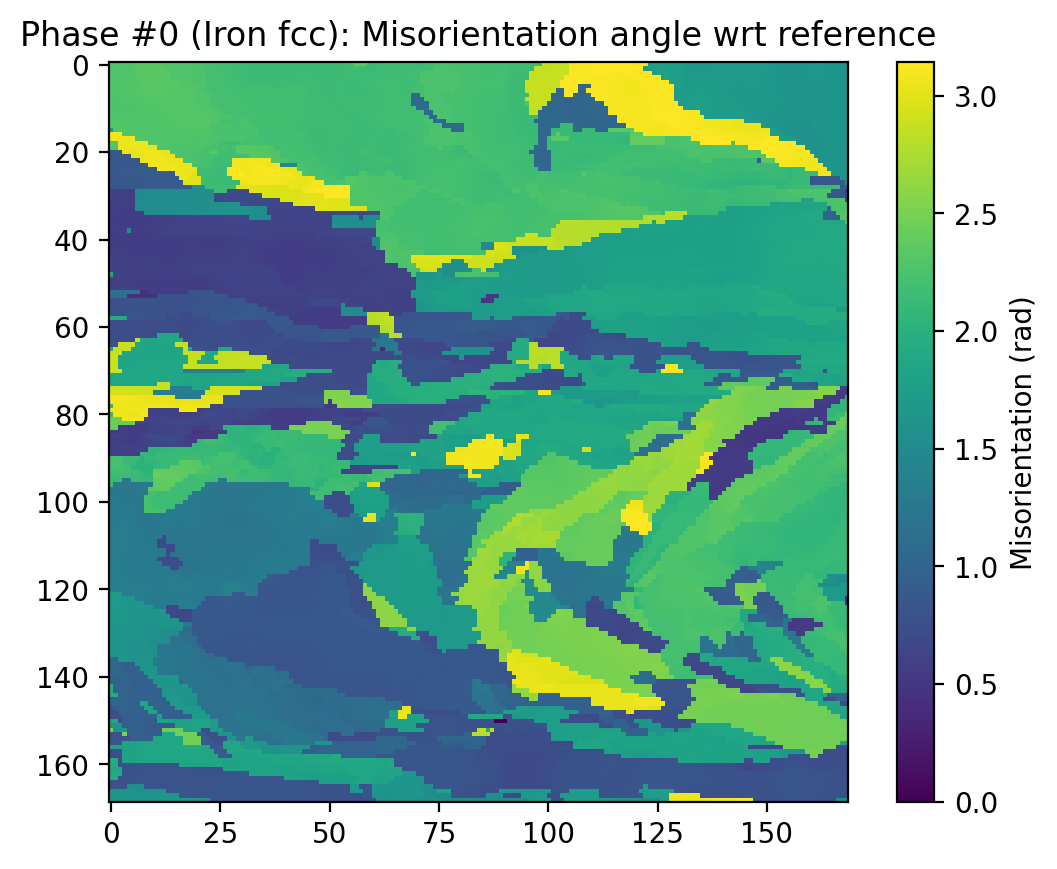

/mnt/c/Users/youse/kanapy/src/kanapy/texture.py:1371: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


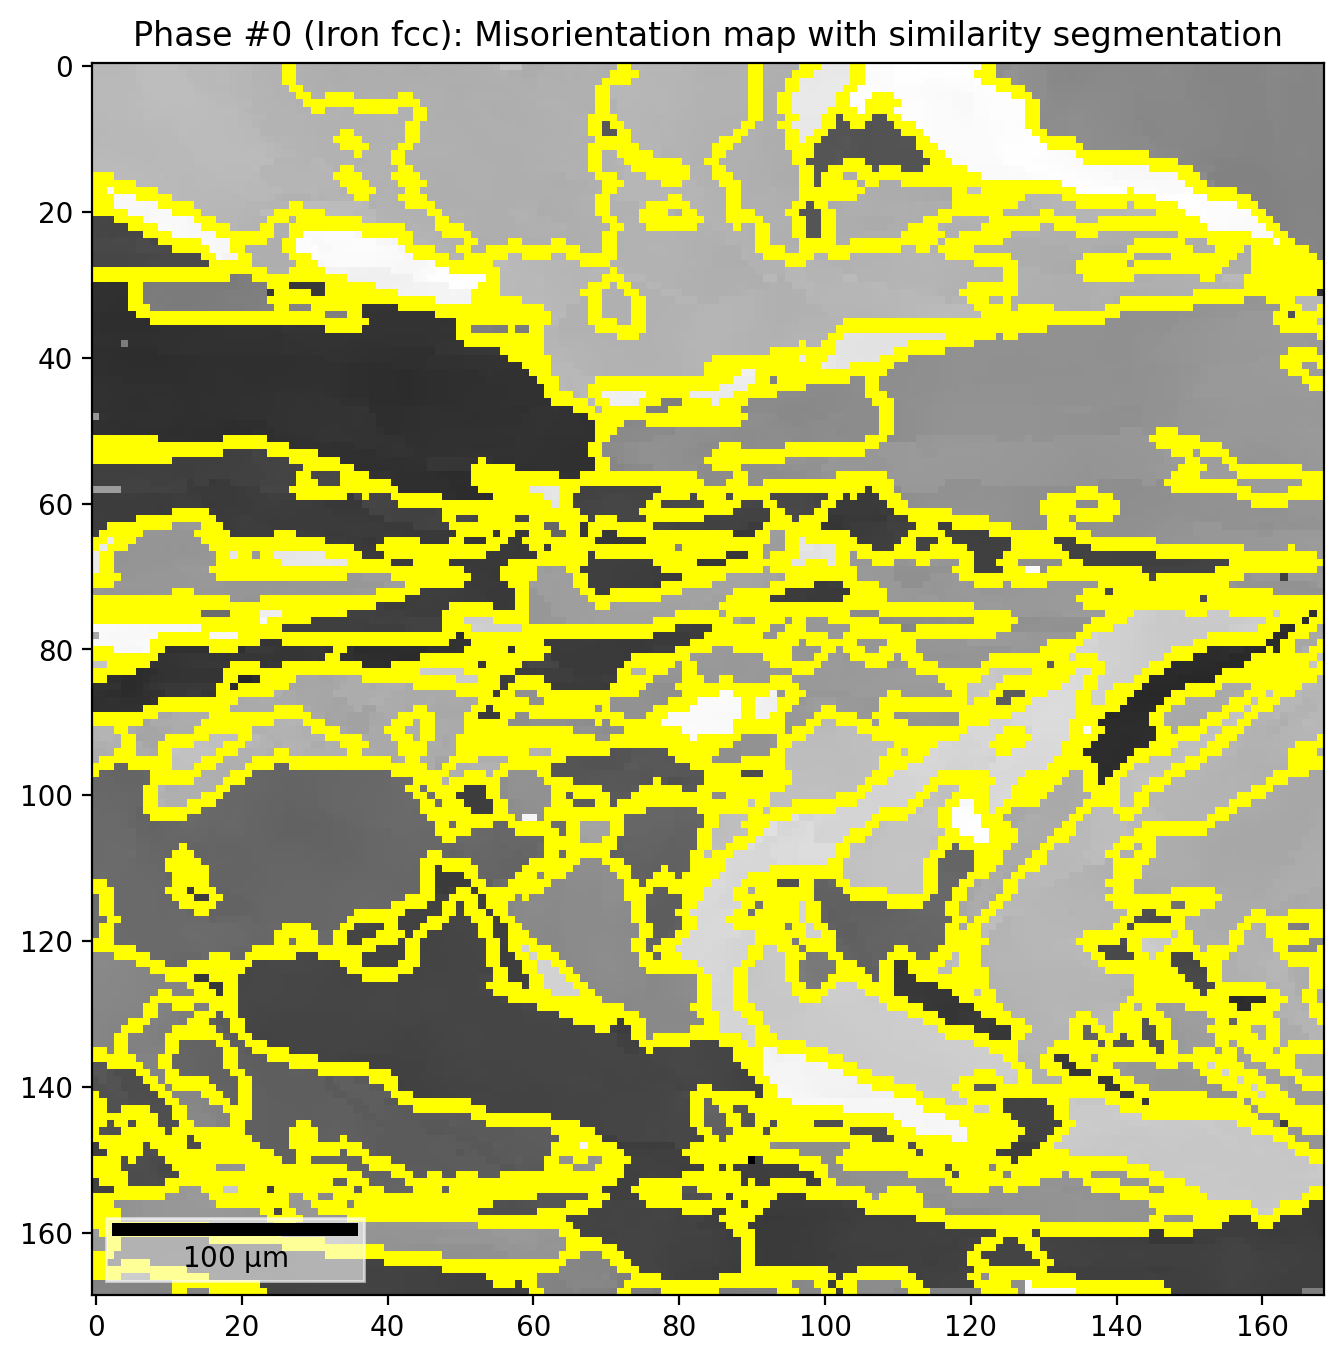

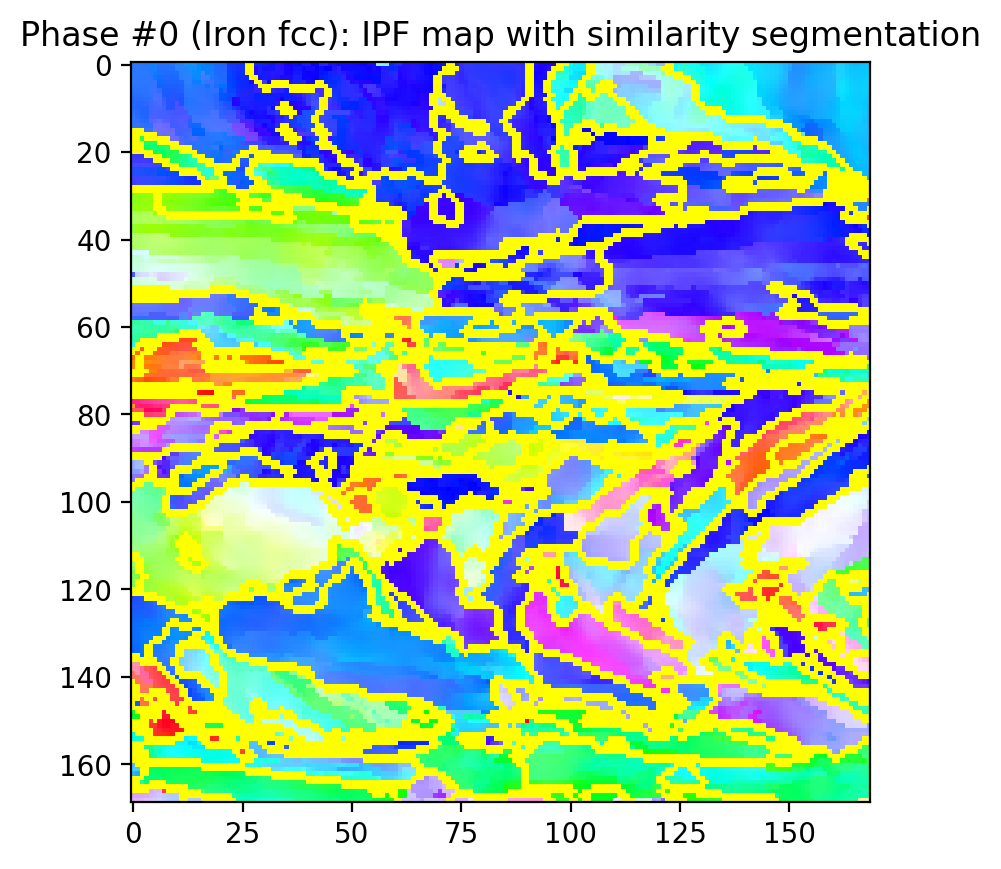

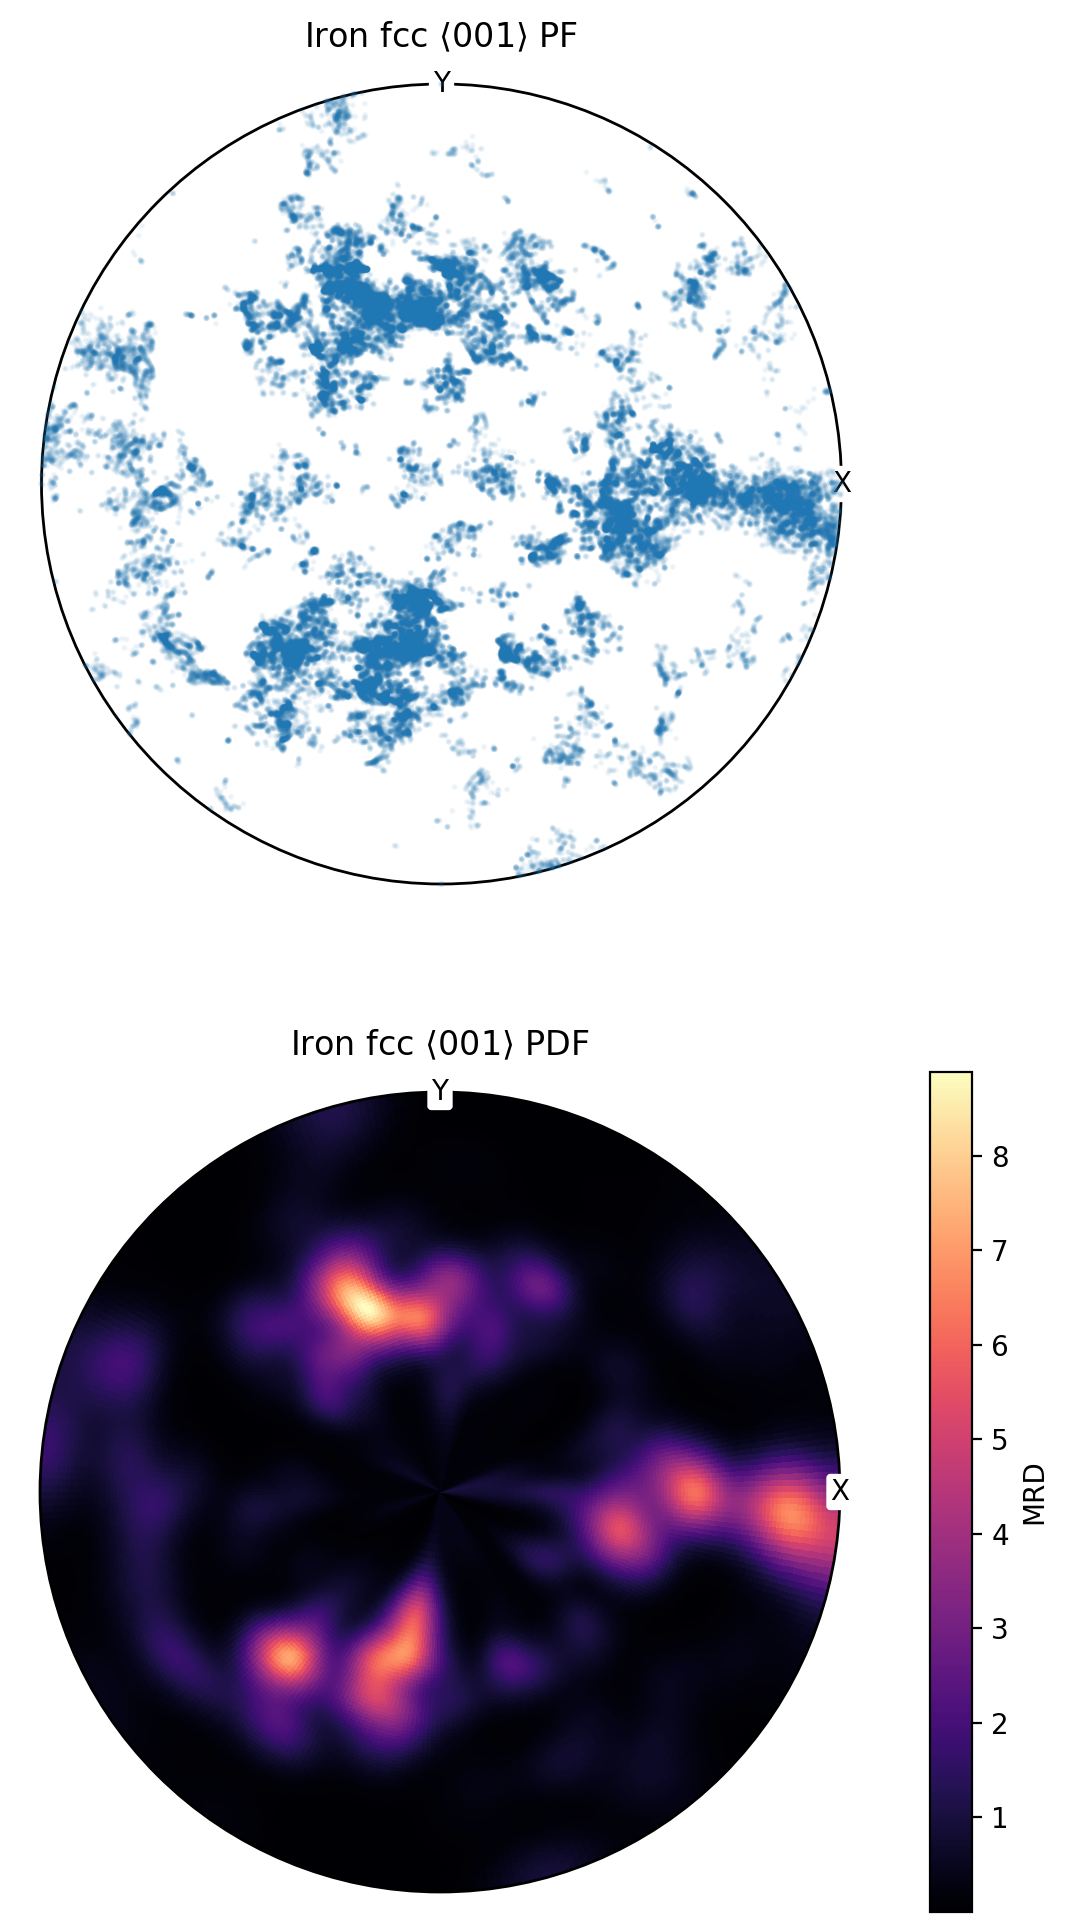

Step 2 completed: EBSD map loaded from ebsd_316L_500x500.ang
######################################################################################




########################################################################################
Step 3: Extracting microstructure statistics .........................................



Step 3 completed: Microstructure statistics extracted................................
#####################################################################################




########################################################################################
Step 4: Generating RVE ...............................................................



Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of particles  = 20
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (30, 30, 30) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1. 1. 1.](um)
    Tota

100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [00:28<00:00, 51.32it/s]


Actual final volume of ellipsoids: 16908.80212861706
Completed particle packing
104 overlapping particles detected after packing
Kinetic energy of particles after packing: 82627.95798535085






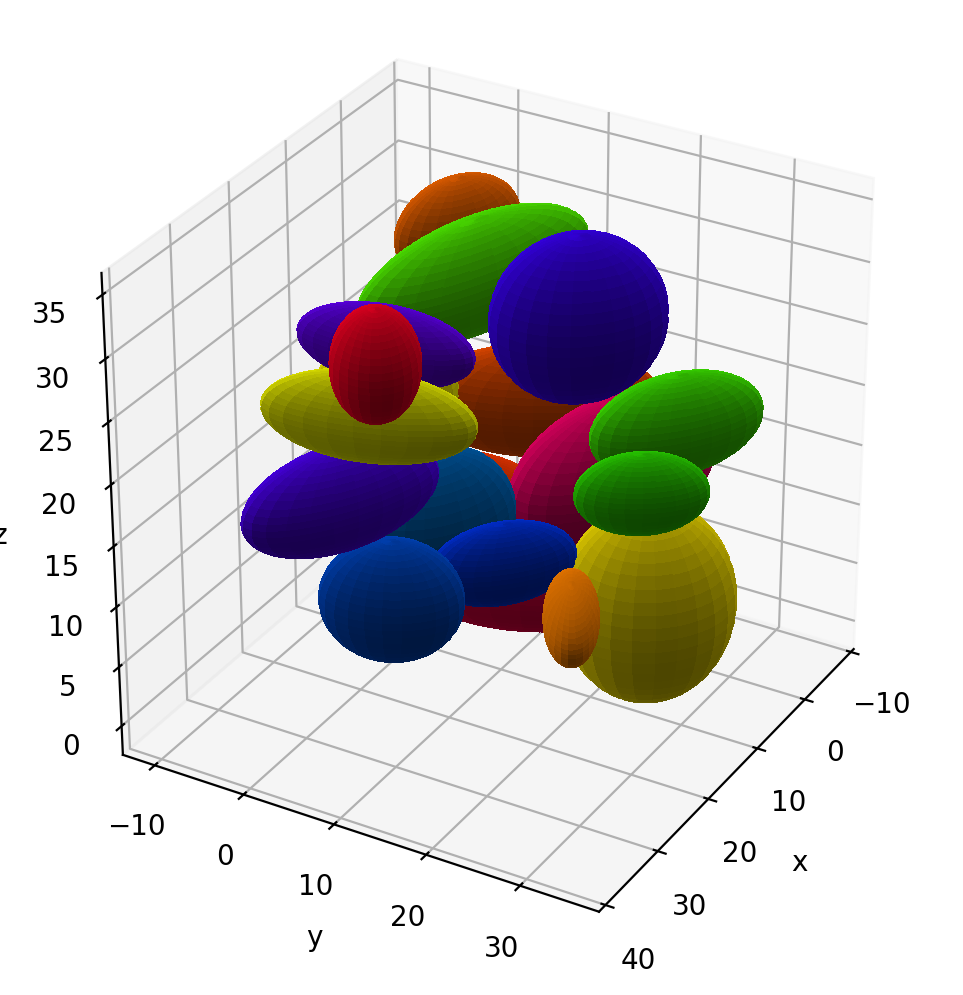

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|███████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 12867425.07it/s]


Completed RVE voxelization






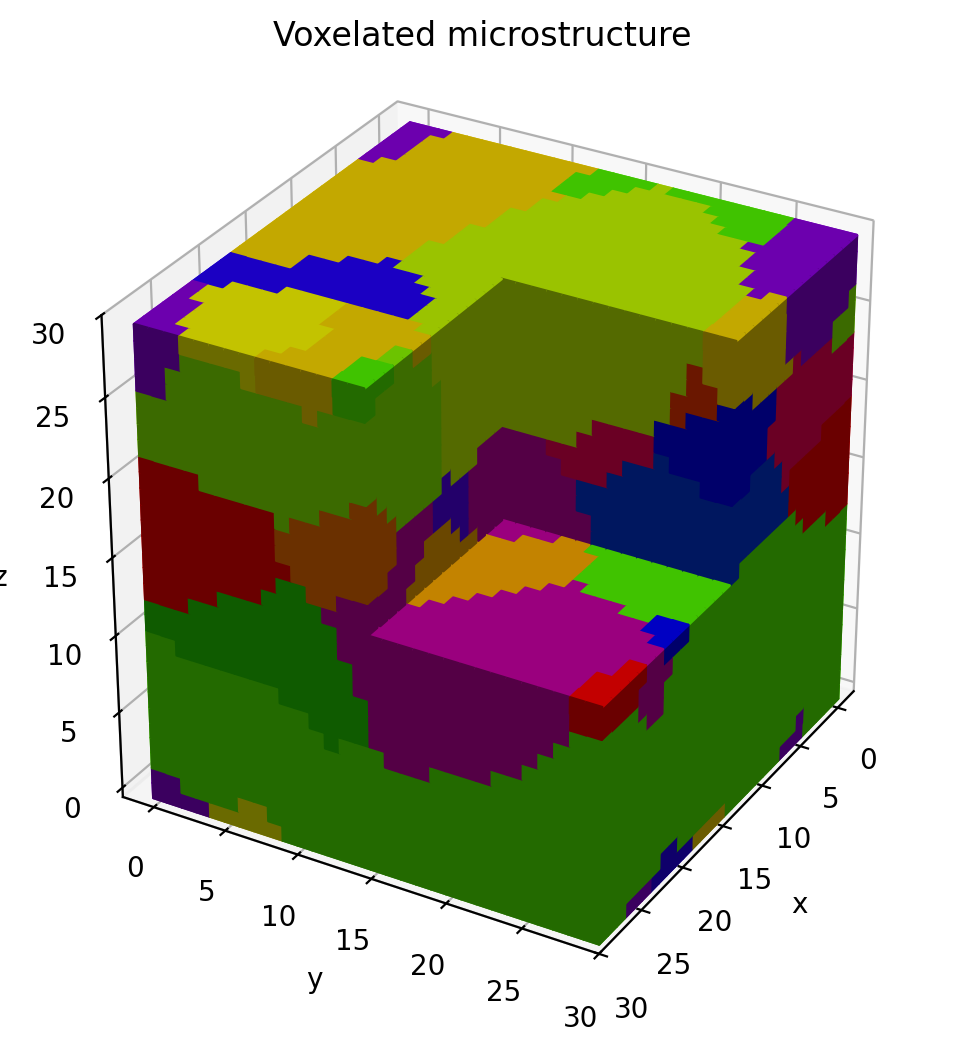

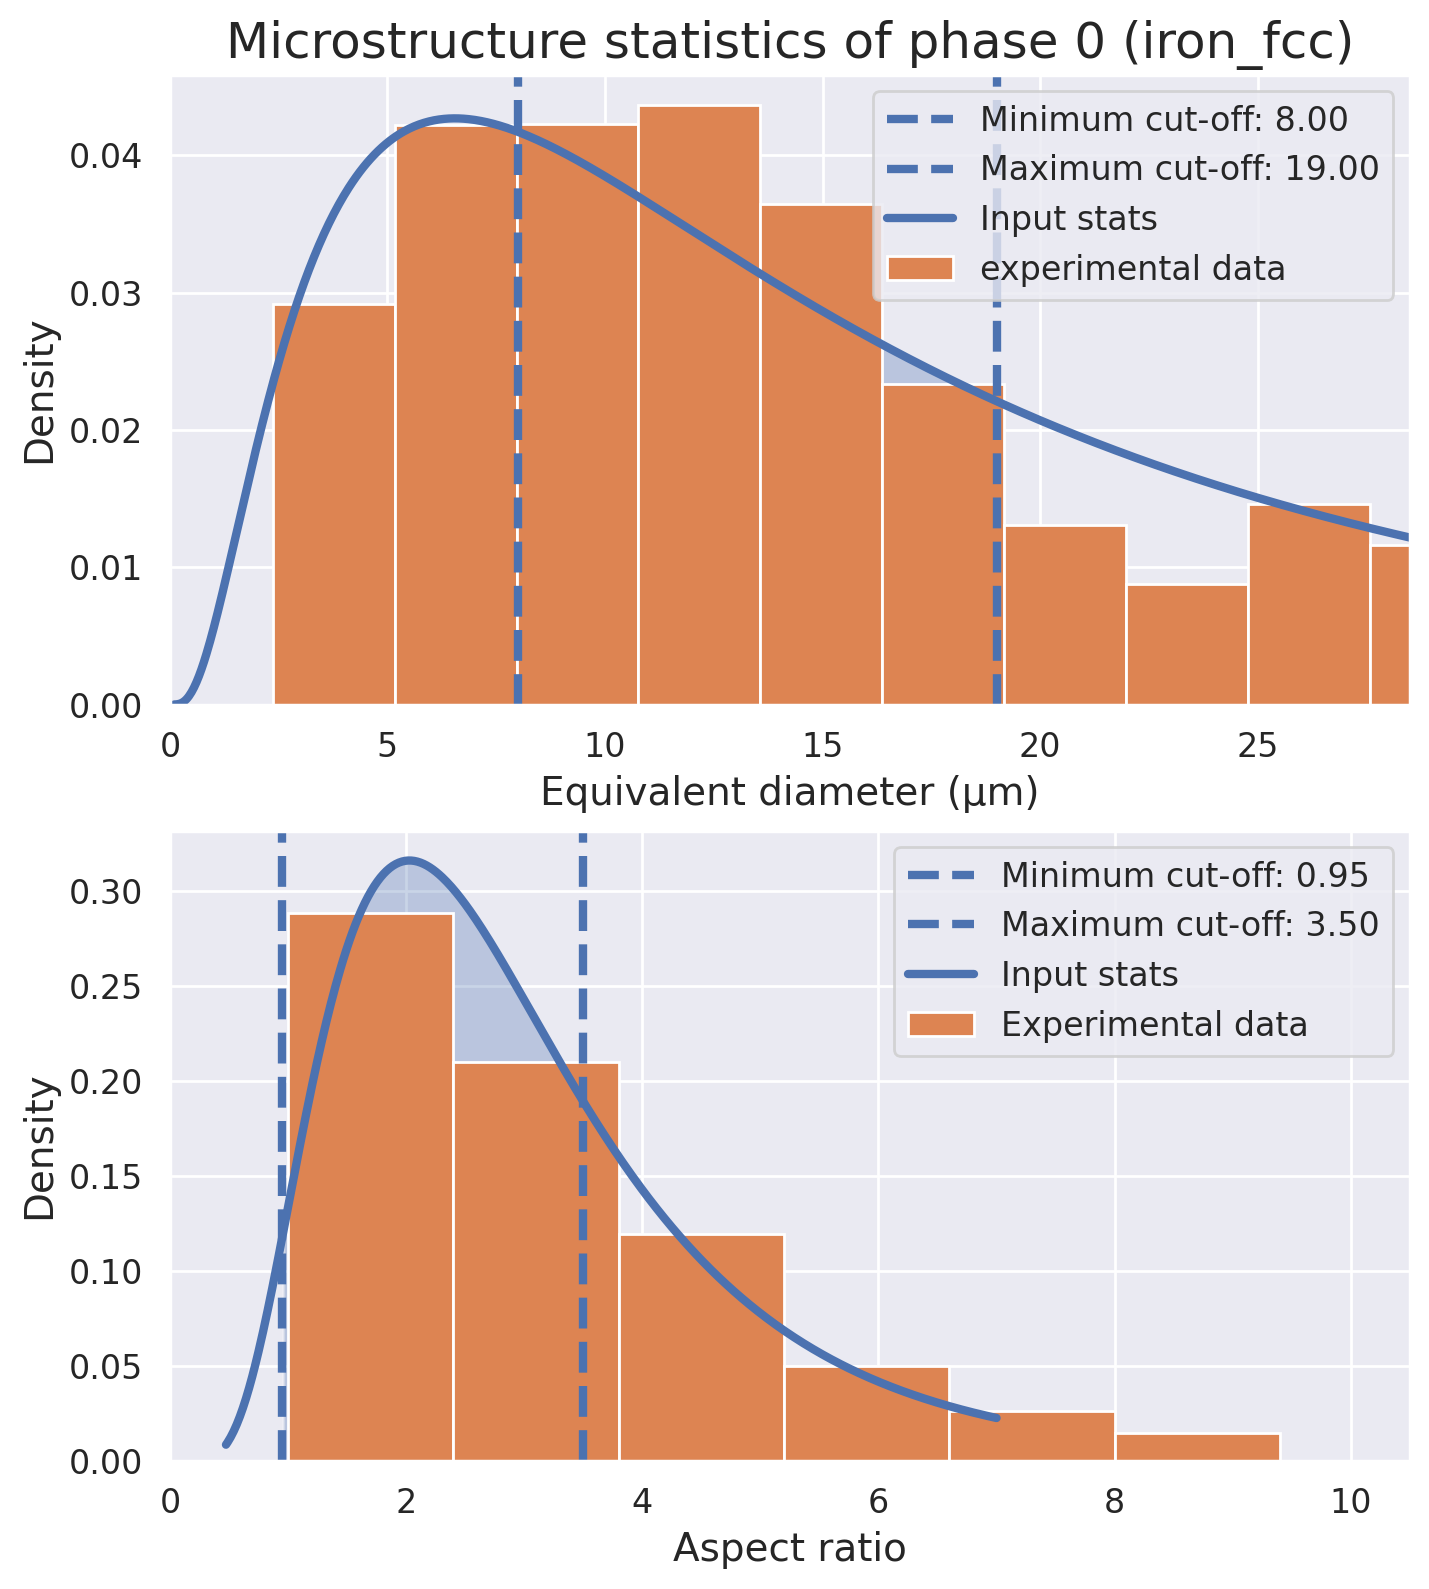

INFO:root:Using ORIX library to read EBSD maps and generate orientations.


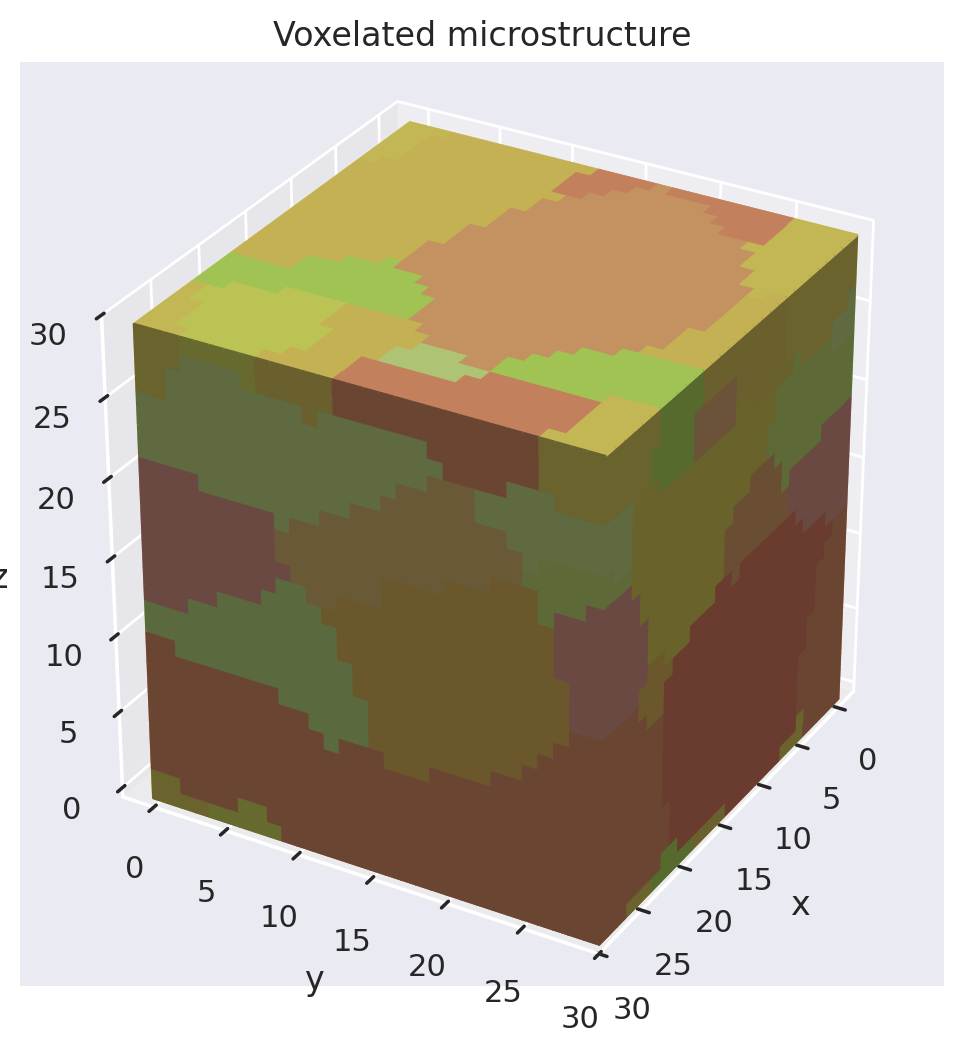

Step 4 completed: RVE generated.......................................................
######################################################################################




########################################################################################
Step 5: Exporting data ...............................................................






type: <class 'dict'>



preview: {'identifier': 'c779c1a4', 'title': 'Stress-Strain Analysis...', 'date': '2025-08-01', 'description': 'Stress-strain analysis of polycrystalline copper...', 'rights': 'Creative Commons Attribution 4.0





INFO:damask._configmaterial:
INFO:damask._configmaterial:


Saved to: /home/yousef/damaskWorkflows/ebsd2kanapy2damask/Version3/data_schema_damask.json
Step 5 completed: data saved in JSOn file.............................................
######################################################################################




########################################################################################
Step 6: Building grid/material/load from JSON ........................................



cells:  30 × 30 × 30
size:   30.0 × 30.0 × 30.0 m³
origin: 0.0   0.0   0.0 m
# materials: 20



homogenization:
  direct:
    N_constituents: 1
    mechanical: {type: pass}
phase: {'0': null}
material:
- constituents:
  - phase: '0'
    O: [0.4722518921565242, 0.356386855728486, 0.12961242648685353, 0.7957180268906416]
    v: 1.0
  homogenization: direct
- constituents:
  - phase: '0'
    O: [0.5887302592803834, -0.2574360729301238, -0.3356025046670844, -0.6888354731161486]
    v: 1.0
  homogenization: direct
- constituents:
  - phase: '0'
    O:

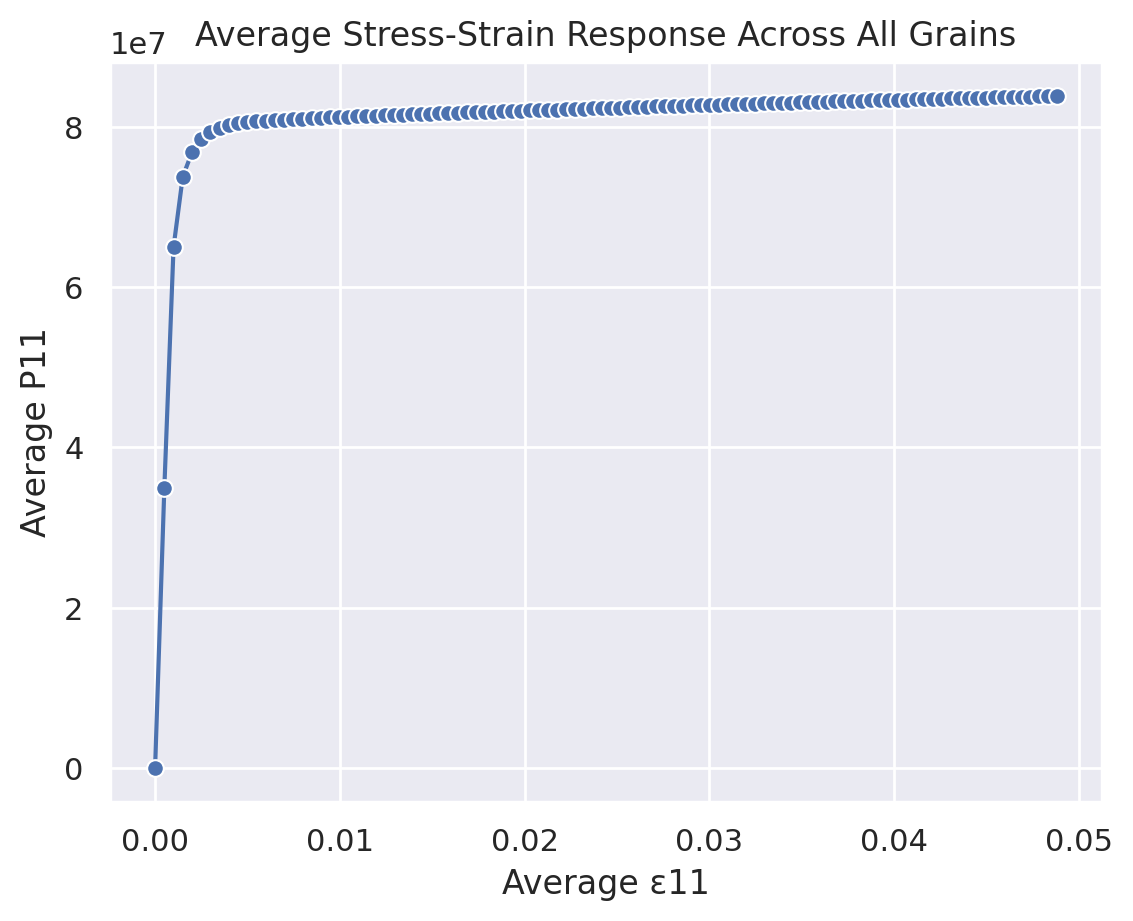

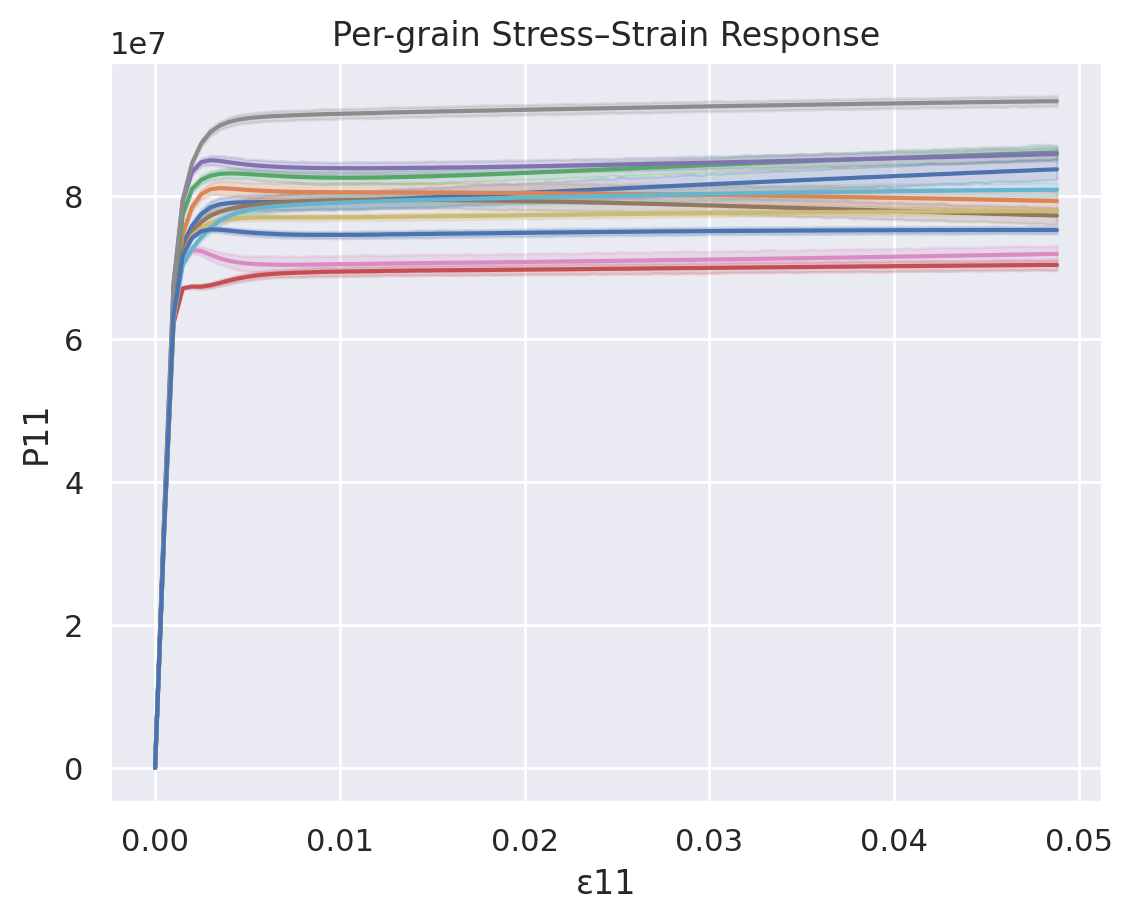

INFO:pyiron_log:Assigning a channel with the label None to the io key post_processing__None


##################################################################################################
Step 8 completed: End of postprocessing ........................................................



Workflow completed successfully. Json file has been generated.


In [13]:
try:
    wf.run() # Run the workflow
    print("Workflow completed successfully. Json file has been generated.")
except Exception as e:
    print(f"An error occurred during the workflow execution: {str(e)}")

INFO:pyiron_log:Assigning a channel with the label file_extension to the io key locate_map_dir__file_extension
INFO:pyiron_log:Assigning a channel with the label path to the io key locate_map_dir__path
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key load_ebsd_map__show_plot
INFO:pyiron_log:Assigning a channel with the label NVoxels to the io key get_stats__NVoxels
INFO:pyiron_log:Assigning a channel with the label sizeRVE to the io key get_stats__sizeRVE
INFO:pyiron_log:Assigning a channel with the label periodic to the io key get_stats__periodic
INFO:pyiron_log:Assigning a channel with the label show_plots to the io key generate_rve__show_plots
INFO:pyiron_log:Assigning a channel with the label fileName to the io key write_data__fileName
INFO:pyiron_log:Assigning a channel with the label user_metadata to the io key write_data__user_metadata
INFO:pyiron_log:Assigning a channel with the label boundary_condition to the io key write_data__boundary_condition
INFO

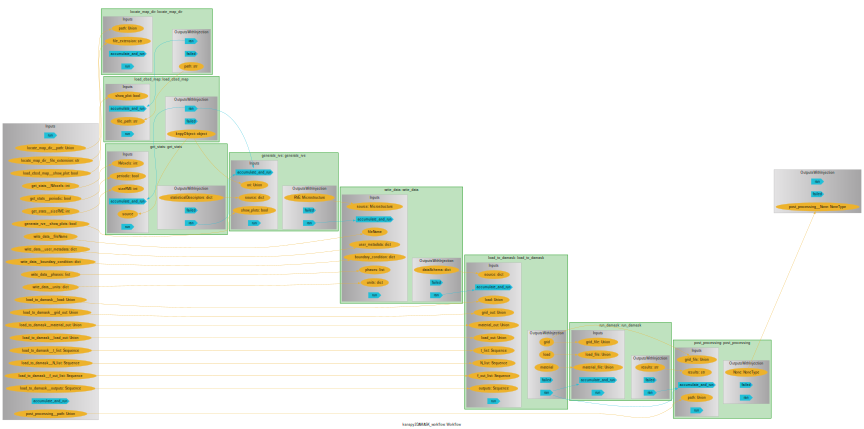

In [14]:
wf.draw(size=(12,10))